# Full code and figures for main results
Original scripts are in our individual ipynbs

In [ ]:
! git clone https://github.com/Catherine-Nguyen88/project_chd

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression

### Data cleaning and eda
Data cleaning is taken from cleaning_data.ipynb

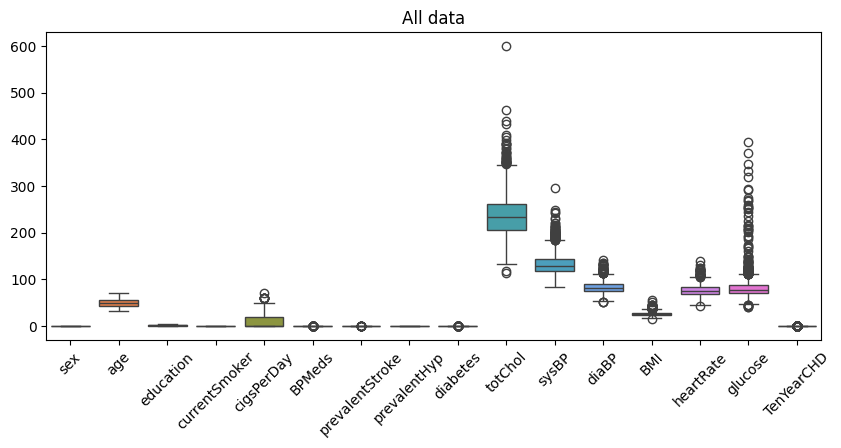

train_data with outliers
(2744, 16)
(2691, 16)


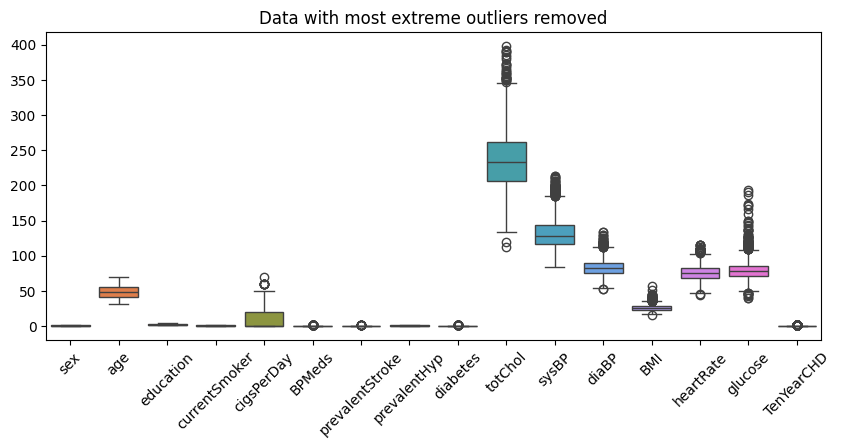

In [3]:
# Read in and clean data
train_data = pd.read_csv('./project_chd/fhs_train.csv')
test_data = pd.read_csv('./project_chd/fhs_test.csv')

# clean training data
train_data1 = train_data.loc[:,['sex', 'age', 'education', 'currentSmoker', 'cigsPerDay',
       'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol',
       'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']]
train_final = train_data1
train_final1 = train_final.dropna()

# clean testing data
test_data1 = test_data.loc[:,['sex', 'age', 'education', 'currentSmoker', 'cigsPerDay',
       'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol',
       'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']]
test_final = test_data1
test_final1 = test_final.dropna()

# outliers are present in the data
plt.figure(figsize=(10,4))
sns.boxplot(data=train_final1)
plt.xticks(rotation=45)
plt.title("All data")
plt.show()

# remove outliers before proceeding
print('train_data with outliers')
print(train_final1.shape)
train_final1 = train_final1.loc[train_final1['sysBP']<215,:]
train_final1 = train_final1.loc[train_final1['diaBP']<150,:]
train_final1 = train_final1.loc[train_final1['glucose']<200,:]
train_final1 = train_final1.loc[train_final1['totChol']<400,:]
train_final1 = train_final1.loc[train_final1['heartRate']<120,:]
print(train_final1.shape)

plt.figure(figsize=(10,4))
sns.boxplot(data=train_final1)
plt.xticks(rotation=45)
plt.title("Data with most extreme outliers removed")
plt.show()

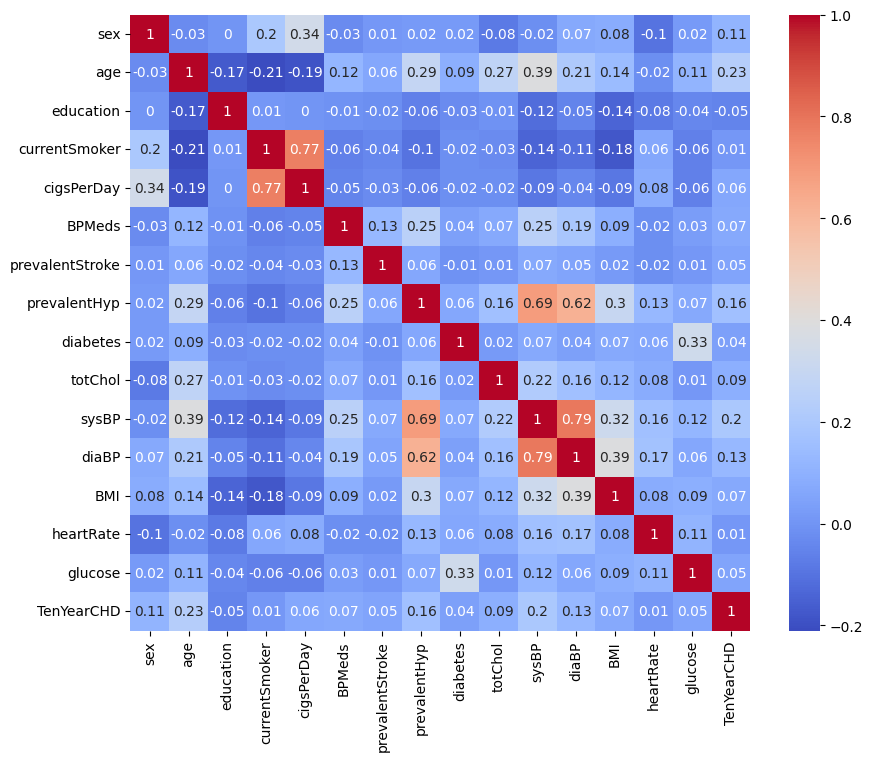

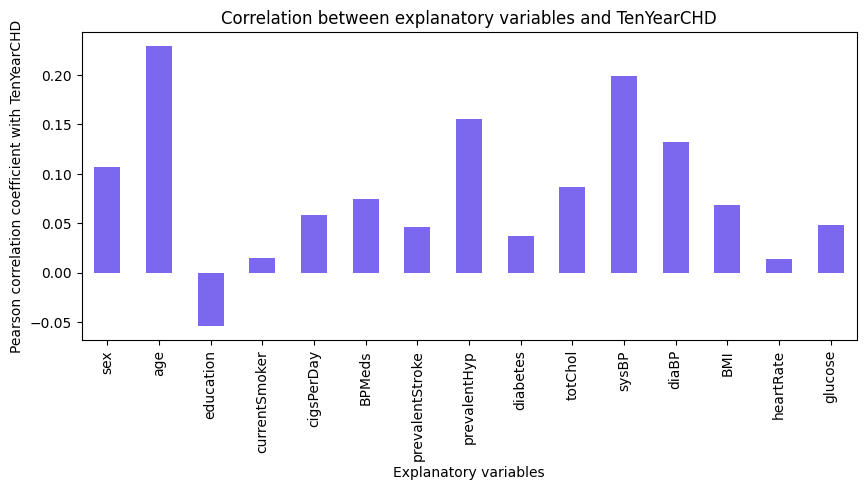

In [5]:
corr_matrix = train_final1.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.round(2), annot=True, cmap='coolwarm')
plt.show()

# Correlation of X with Y
corr_XY = train_final1.corr().iloc[-1, :-1]
plt.figure(figsize=(10, 4))
corr_XY.plot(kind='bar',color='mediumslateblue')
plt.title("Correlation between explanatory variables and TenYearCHD")
plt.xlabel("Explanatory variables")
plt.ylabel("Pearson correlation coefficient with TenYearCHD")
plt.show()

**Linear regression**

In [19]:
# all variables
y = train_final1['TenYearCHD']
vars = ['sex','currentSmoker','cigsPerDay','diabetes','totChol','sysBP','diaBP','BMI',
        'age','prevalentStroke','prevalentHyp','heartRate','glucose','BPMeds','education']
X = train_final1.loc[:,vars]

X_test = test_final1.loc[:,vars]
y_test = test_final1['TenYearCHD']

# linear regression
linear_reg = LinearRegression()
linear_reg.fit(X, y) # fit linear regression using the predicted classes

# predict test data
lin_pred = linear_reg.predict(X_test)

rmse = np.sqrt( np.mean( (y_test - lin_pred)**2 ))
print('RMSE: ')
print(rmse)

print('R squared: ')
print(linear_reg.score(X_test, y_test))

results = pd.DataFrame({'variable':linear_reg.feature_names_in_, 'coefficient': linear_reg.coef_}) # Regression coefficients
results

RMSE: 
0.3353266421186211
R squared: 
0.09567229375692166


,variable,coefficient
0,sex,0.066141
1,currentSmoker,-0.009411
2,cigsPerDay,0.002565
3,diabetes,0.015888
4,totChol,0.000125
5,sysBP,0.002406
6,diaBP,-0.001407
7,BMI,-0.000172
8,age,0.007569
9,prevalentStroke,0.114710


In [20]:
# dropping 3 least influential variables
y = train_final1['TenYearCHD']
vars = ['sex','currentSmoker','cigsPerDay','diabetes','sysBP','diaBP',
        'age','prevalentStroke','prevalentHyp','glucose','BPMeds','education']
X = train_final1.loc[:,vars]

X_test = test_final1.loc[:,vars]
y_test = test_final1['TenYearCHD']

# linear regression
linear_reg = LinearRegression()
linear_reg.fit(X, y) # fit linear regression using the predicted classes

# predict test data
lin_pred = linear_reg.predict(X_test)

rmse = np.sqrt( np.mean( (y_test - lin_pred)**2 ))
print('RMSE: ')
print(rmse)

print('R squared: ')
print(linear_reg.score(X_test, y_test))

results = pd.DataFrame({'variable':linear_reg.feature_names_in_, 'coefficient': linear_reg.coef_}) # Regression coefficients
results

RMSE: 
0.3349423663008855
R squared: 
0.09774377932143263


,variable,coefficient
0,sex,0.064906
1,currentSmoker,-0.008996
2,cigsPerDay,0.002594
3,diabetes,0.016066
4,sysBP,0.002436
5,diaBP,-0.001403
6,age,0.007720
7,prevalentStroke,0.113911
8,prevalentHyp,0.017489
9,glucose,0.000300


**Decision trees**

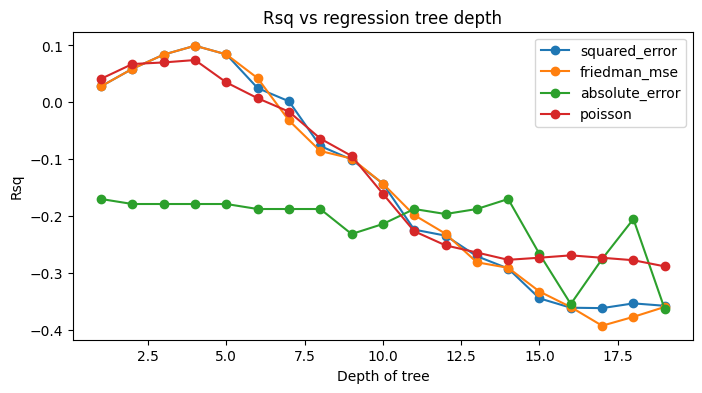

In [6]:
# process data
y = train_final1['TenYearCHD']
vars =  ['sex','currentSmoker','cigsPerDay','diabetes','totChol','sysBP','diaBP','BMI',
        'age','prevalentStroke','prevalentHyp','heartRate','glucose','BPMeds','education']
X = train_final1.loc[:,vars]

X_test = test_final1.loc[:,vars]
y_test = test_final1['TenYearCHD']

depths = np.arange(1,20,1)
rsq_results = {}
RMSE_results = {}

criterions = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
for crit in criterions:
  rsq = []
  RMSE = []
  for dep in depths:
    # fit decision tree with given depth
    cart = DecisionTreeRegressor(max_depth=dep,criterion=crit,min_samples_split=20)
    cart = cart.fit(X,y) # fit the regression
    var_names = cart.feature_names_in_

    # make predictions on the test set
    y_hat = cart.predict(X_test)

    # residuals, rsq, rmse
    e = y_test - y_hat
    rsq_val = 1-np.sum(e**2)/np.sum((y_test - np.mean(y))**2)
    rsq.append(rsq_val)
    rmse_val = np.sqrt(np.mean(e**2))
    RMSE.append(rmse_val)

  rsq_results[crit] = rsq
  RMSE_results[crit] = RMSE

plt.figure(figsize=(8,4))
for crit in criterions:
  plt.plot(depths,rsq_results[crit],marker='o',label=crit)
plt.title("Rsq vs regression tree depth")
plt.legend()
plt.xlabel("Depth of tree")
plt.ylabel("Rsq")
plt.show()

Remove variables that had least predictive power.

Removing variables does not improve the rsq

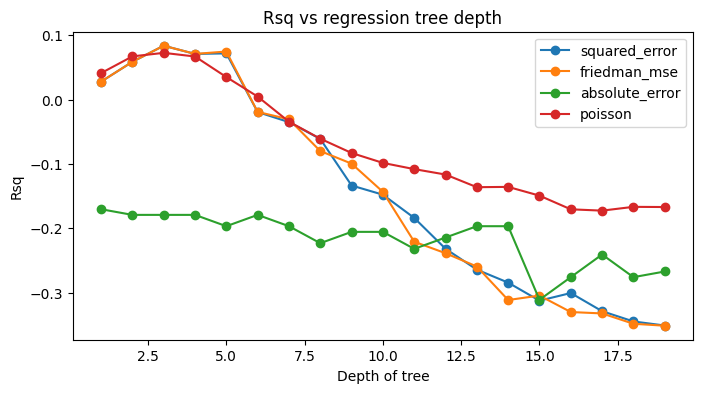

In [16]:
y = train_final1['TenYearCHD']
vars =  ['sex','currentSmoker','cigsPerDay','diabetes','sysBP','diaBP',
        'age','prevalentStroke','prevalentHyp','glucose','BPMeds','education']
X = train_final1.loc[:,vars]

X_test = test_final1.loc[:,vars]
y_test = test_final1['TenYearCHD']

depths = np.arange(1,20,1)
rsq_results = {}
RMSE_results = {}

criterions = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
for crit in criterions:
  rsq = []
  RMSE = []
  for dep in depths:
    # fit decision tree with given depth
    cart = DecisionTreeRegressor(max_depth=dep,criterion=crit,min_samples_split=20)
    cart = cart.fit(X,y) # fit the regression
    var_names = cart.feature_names_in_

    # make predictions on the test set
    y_hat = cart.predict(X_test)

    # residuals, rsq, rmse
    e = y_test - y_hat
    rsq_val = 1-np.sum(e**2)/np.sum((y_test - np.mean(y))**2)
    rsq.append(rsq_val)
    rmse_val = np.sqrt(np.mean(e**2))
    RMSE.append(rmse_val)

  rsq_results[crit] = rsq
  RMSE_results[crit] = RMSE

plt.figure(figsize=(8,4))
for crit in criterions:
  plt.plot(depths,rsq_results[crit],marker='o',label=crit)
plt.title("Rsq vs regression tree depth")
plt.legend()
plt.xlabel("Depth of tree")
plt.ylabel("Rsq")
plt.show()

**KNN**

k: 3, MSE: 124.0
k: 10, MSE: 110.80000000000001
k: 25, MSE: 108.74080000000001
k: 50, MSE: 107.27120000000001
k: 100, MSE: 107.2928
k: 101, MSE: 107.2153710420547
k: 125, MSE: 106.95436800000002
k: 150, MSE: 106.45657777777777
k: 200, MSE: 106.83737500000001
k: 300, MSE: 107.1123111111111
[153]


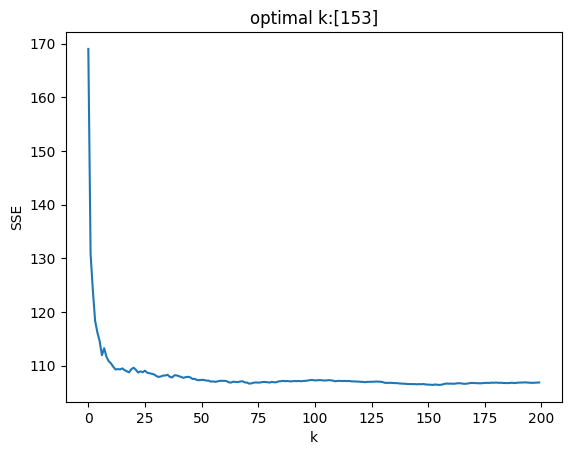

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#Splitting Sample
y_train = train_final1['TenYearCHD']
x_train = train_final1.drop('TenYearCHD', axis=1)

y_test = test_final1['TenYearCHD']
x_test = test_final1.drop('TenYearCHD', axis=1)

#Maxmin Normlize
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#KNN Regressor
for k in [3, 10, 25, 50, 100, 101, 125, 150, 200, 300]:
  model = KNeighborsRegressor(n_neighbors=k).fit(x_train_scaled, y_train)
  yhat = model.predict(x_test_scaled)
  mse = np.sum((y_test - yhat)**2)
  print('k: '+str(k)+', MSE: '+str(mse))

#Optimal K for the data
kbar = 200
kgrid = np.arange(1,kbar)
SSE = np.zeros(kbar)

for k in range(kbar):
  fitModel = KNeighborsRegressor(n_neighbors=k+1).fit(x_train_scaled, y_train)
  yhat = fitModel.predict(x_test_scaled) #Predict for values test
  SSE[k] = np.sum((y_test - yhat)**2)

SSEmin = np.min(SSE) #Lowest SSE
minIndex = np.where(SSE==SSEmin)
kstar = kgrid[minIndex]
print(kstar)

plt.plot(np.arange(0,kbar), SSE)
plt.xlabel("k")
plt.title("optimal k:"+str(kstar))
plt.ylabel('SSE')
plt.show()

106.38100730488274


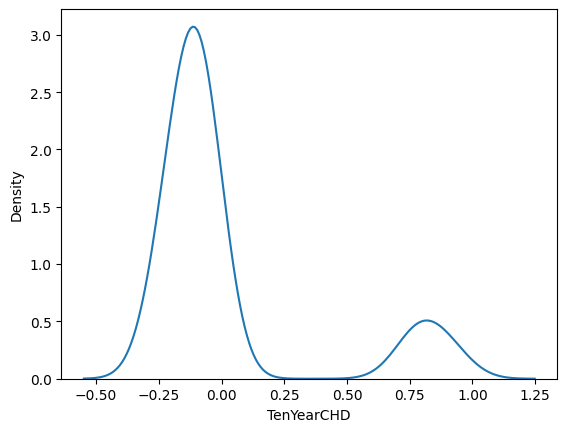

R-squared: 0.06396207803710885
RMSE: 0.3411606642065305


In [18]:
#Re-training the model with the best K value
model1 = KNeighborsRegressor(n_neighbors=153).fit(x_train_scaled, y_train)
yhat1 = model1.predict(x_test_scaled)
mse = np.sum((y_test - yhat1)**2)
print(mse)
#The mean-squared error of a KNN model with k=153 is 106

#Residuals, R-Squared, RMSE
error = y_test - yhat1
sns.kdeplot(error)
plt.show()
rsq = 1-np.sum(error**2)/np.sum((y_test-np.mean(y_train))**2)
rmse = np.sqrt(np.mean(error**2))

print('R-squared:', rsq)
print('RMSE:', rmse)